In [1]:
import SingleLeg_Animation
import numpy as np
from LegModel import *
from Contact_Map import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Arc
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from CollisionCheck import *
import math
from scipy.optimize import fsolve
from utils import *
import inv_move_kinematics
from matplotlib.backends.backend_pdf import PdfPages

pi = np.pi
contact_map = ContactMap()
linkleg = contact_map.leg.linkleg
r = linkleg.r
outer_radius = linkleg.R + r
radius = linkleg.R

contact_map2 = ContactMap()
linkleg2 = contact_map2.leg.linkleg

theta_list = []
beta_list = []
for theta in range(17, 161):
    theta = np.deg2rad(theta)
    for beta in range(0, 360):
        beta = np.deg2rad(beta)
        theta_list.append(theta)
        beta_list.append(beta)

theta_list = np.array(theta_list)
beta_list = np.array(beta_list)
contact_map.mapping(theta_list, beta_list)

def rotate(start, angle):   # point, degree -> rotate point about origin
    angle = angle *np.pi /180
    start = np.array(start)
    return    (np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle),  np.cos(angle)]]) @ start.reshape(-1, 1)).reshape(-1)

Leg configuration

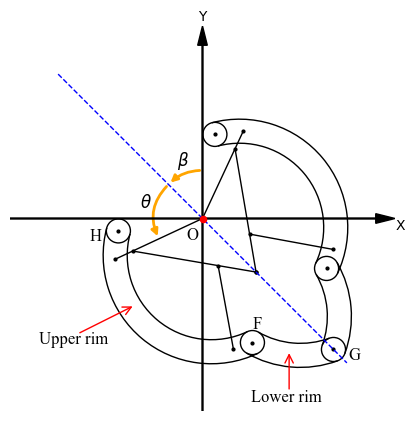

In [2]:
contact_map2.calculate(np.deg2rad(70), np.deg2rad(45))

fig_size = 5
fig, ax = plt.subplots(figsize = (fig_size,fig_size))
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体
plt.rcParams['font.size'] = 12  # 设置字体大小

# plot leg
Animation = SingleLeg_Animation.SingleLeg_Animation()
ax = Animation.plot_one(np.deg2rad(70), np.deg2rad(45), [0, 0], ax)
G = linkleg2.G
F = linkleg2.F
H = linkleg2.H
ax.scatter(0, 0, s=20.0, color='r', zorder=20)

ax.plot([-0.15, 0.15], [0.15, -0.15], 'b--', linewidth=1) # line of symmetry
start_point = np.array([0, 0.05])
arc = FancyArrowPatch(start_point, rotate(start_point, 45), connectionstyle="angle3,angleA=180,angleB=225", 
                        arrowstyle="-|>", color="orange", linewidth=2, mutation_scale=10)   # beta arc arrow
ax.add_patch(arc)
arc = FancyArrowPatch(rotate(start_point, 45), rotate(start_point, 45+70), connectionstyle="angle3,angleA=225,angleB=295", 
                        arrowstyle="-|>", color="orange", linewidth=2, mutation_scale=10)   # theta arc arrow
ax.add_patch(arc)
# arc = Arc((0, 0), 0.1, 0.1, angle=0, theta1=135, theta2=135+70, color='blue', linewidth=1)  # theta arc
# ax.add_patch(arc)
# arc = Arc((0, 0), 0.2,0.2, angle=0, theta1=90, theta2=90+45, color='blue', linewidth=2)  
# ax.add_patch(arc)

# axis setting
ax.spines[:].set_visible(False) # no 4 sides
ax.xaxis.set_ticks([])  # no tick
ax.yaxis.set_ticks([])
# ax.set_title("/beta")
ax.set_xlabel("Y")
ax.xaxis.set_label_position('top')
ax.set_ylabel("X", rotation=0)
ax.yaxis.set_label_position('right')
ax.arrow(-0.2, 0, 0.4-0.02, 0, head_width=0.01, head_length=0.02, fc='black', ec='black') # x axis arrow
ax.arrow(0, -0.2, 0, 0.4-0.02, head_width=0.01, head_length=0.02, fc='black', ec='black') # y axis arrow

# text
ax.text(-0.065,  0.012, r'$\theta$')  # theta
ax.text(-0.027,  0.055, r'$\beta$')  # beta
ax.text(-0.017,  -0.022, 'O') # O
ax.text(G.real+0.015,  G.imag-0.01, 'G') # G
ax.text(F.real,  F.imag+0.015, 'F') # F
ax.text(H.real-0.03,  H.imag-0.01, 'H') # H
# Upper rim
ax.text(-0.17, -0.13, 'Upper rim') 
arrow = FancyArrowPatch((-0.13, -0.12), (-0.07, -0.09), arrowstyle='->', color='red', mutation_scale=15)
ax.add_patch(arrow)
# Lower rim
ax.text(0.05, -0.19, 'Lower rim') 
arrow = FancyArrowPatch((0.09, -0.18), (0.09, -0.137), arrowstyle='->', color='red', mutation_scale=15)
ax.add_patch(arrow)

# save as pdf
pdf = PdfPages('leg-wheel.pdf')
pdf.savefig(bbox_inches='tight', pad_inches=0)
pdf.close()

# show
plt.show()

Radian value for each point on the rim

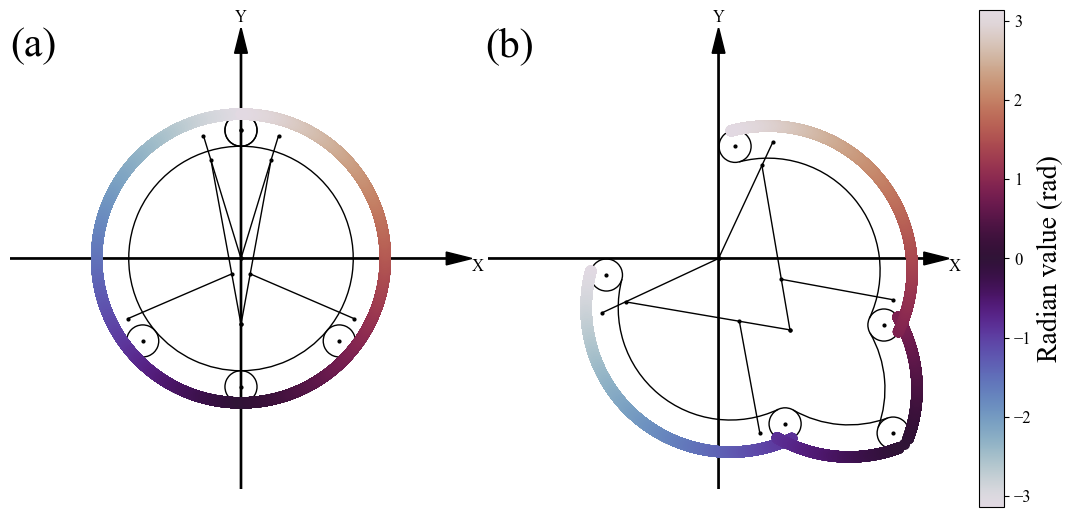

In [3]:
fig_size = 5
fig, axs = plt.subplots(1, 2, figsize=(2*fig_size, fig_size))
p_size = 50
Animation = SingleLeg_Animation.SingleLeg_Animation()

#### wheel mode ####
axs[0].set_aspect('equal')  # 座標比例相同
rim_point = []  # all point on rim
contact_map2.calculate(np.deg2rad(17), np.deg2rad(0))
O1 = np.array([linkleg2.O1.real, linkleg2.O1.imag]) 
O1_c = np.array([linkleg2.O1_c.real, linkleg2.O1_c.imag]) 
O2 = np.array([linkleg2.O2.real, linkleg2.O2.imag]) 
O2_c = np.array([linkleg2.O2_c.real, linkleg2.O2_c.imag]) 
H = np.array([linkleg2.H.real, linkleg2.H.imag])
H_c = np.array([linkleg2.H_c.real, linkleg2.H_c.imag])
F = np.array([linkleg2.F.real, linkleg2.F.imag])
F_c = np.array([linkleg2.F_c.real, linkleg2.F_c.imag])
G = np.array([linkleg2.G.real, linkleg2.G.imag])
for deg in np.arange(0, 130, 0.01):  # left upper rim
    rim_point.append(rotate((H-O1)/radius*outer_radius, deg) + O1)
for deg in np.arange(0, 50, 0.01):
    rim_point.append(rotate((F-O2)/radius*outer_radius, deg) + O2)
rim_point.append(G/np.linalg.norm(G)*(np.linalg.norm(G)+r))
for deg in np.arange(0, 50, 0.01):
    rim_point.append(rotate((G-O2_c)/radius*outer_radius, deg) + O2_c)
for deg in np.arange(0, 130, 0.01):
    rim_point.append(rotate((F_c-O1_c)/radius*outer_radius, deg) + O1_c)
rim_point = np.array(rim_point)
# plot 
radian = np.linspace(-np.pi, np.pi, rim_point.shape[0])  # radian values
cmap = plt.cm.twilight   # color mapping, [viridis, plasma, inferno, magma, Blues, Greens, Reds, coolwarm, RdBu, twilight, Set1, Set2, Set3]
norm = Normalize(vmin=-np.pi, vmax=np.pi)
scatter = axs[0].scatter(rim_point[:, 0], rim_point[:, 1], s=p_size, c=radian, cmap=cmap, norm=norm, zorder=20) # , marker='s', s=sizes
axs[0] = Animation.plot_one(np.deg2rad(17), np.deg2rad(0), [0, 0], axs[0])
axs[0].text(0.1, 1.0, '(a)', transform=axs[0].transAxes,  fontsize=30, va='top', ha='right')
# axis setting
axs[0].spines[:].set_visible(False) # no 4 sides
axs[0].set_xlim(-0.18, 0.18)
axs[0].set_ylim(-0.18, 0.18)
axs[0].xaxis.set_ticks([])  # no tick
axs[0].yaxis.set_ticks([])
axs[0].set_xlabel("Y")
axs[0].xaxis.set_label_position('top')
axs[0].set_ylabel("X", rotation=0)
axs[0].yaxis.set_label_position('right')
axs[0].arrow(-0.18, 0, 0.36-0.02, 0, head_width=0.01, head_length=0.02, fc='black', ec='black') # x axis arrow
axs[0].arrow(0, -0.18, 0, 0.36-0.02, head_width=0.01, head_length=0.02, fc='black', ec='black') # y axis arrow

#### leg mode ####
axs[1].set_aspect('equal')  # 座標比例相同
rim_point = []  # all point on rim
contact_map2.calculate(np.deg2rad(70), np.deg2rad(45))
O1 = np.array([linkleg2.O1.real, linkleg2.O1.imag]) 
O1_c = np.array([linkleg2.O1_c.real, linkleg2.O1_c.imag]) 
O2 = np.array([linkleg2.O2.real, linkleg2.O2.imag]) 
O2_c = np.array([linkleg2.O2_c.real, linkleg2.O2_c.imag]) 
H = np.array([linkleg2.H.real, linkleg2.H.imag])
H_c = np.array([linkleg2.H_c.real, linkleg2.H_c.imag])
F = np.array([linkleg2.F.real, linkleg2.F.imag])
F_c = np.array([linkleg2.F_c.real, linkleg2.F_c.imag])
G = np.array([linkleg2.G.real, linkleg2.G.imag])
for deg in np.arange(0, 130, 0.01):  # left upper rim
    rim_point.append(rotate((H-O1)/radius*outer_radius, deg) + O1)
for deg in np.arange(0, 50, 0.01):
    rim_point.append(rotate((F-O2)/radius*outer_radius, deg) + O2)
rim_point.append(G/np.linalg.norm(G)*(np.linalg.norm(G)+r))
for deg in np.arange(0, 50, 0.01):
    rim_point.append(rotate((G-O2_c)/radius*outer_radius, deg) + O2_c)
for deg in np.arange(0, 130, 0.01):
    rim_point.append(rotate((F_c-O1_c)/radius*outer_radius, deg) + O1_c)
rim_point = np.array(rim_point)
# plot 
radian = np.linspace(-np.pi, np.pi, rim_point.shape[0])  # radian values
cmap = plt.cm.twilight   # color mapping, [viridis, plasma, inferno, magma, Blues, Greens, Reds, coolwarm, RdBu, twilight, Set1, Set2, Set3]
norm = Normalize(vmin=-np.pi, vmax=np.pi)
scatter = axs[1].scatter(rim_point[:, 0], rim_point[:, 1], s=p_size, c=radian, cmap=cmap, norm=norm, zorder=20) # , marker='s', s=sizes
axs[1] = Animation.plot_one(np.deg2rad(70), np.deg2rad(45), [0, 0], axs[1])
axs[1].text(0.1, 1.0, '(b)', transform=axs[1].transAxes,  fontsize=30, va='top', ha='right')

# axis setting
axs[1].spines[:].set_visible(False) # no 4 sides
axs[1].set_xlim(-0.18, 0.18)
axs[1].set_ylim(-0.18, 0.18)
axs[1].xaxis.set_ticks([])  # no tick
axs[1].yaxis.set_ticks([])
axs[1].set_xlabel("Y")
axs[1].xaxis.set_label_position('top')
axs[1].set_ylabel("X", rotation=0)
axs[1].yaxis.set_label_position('right')
axs[1].arrow(-0.18, 0, 0.36-0.02, 0, head_width=0.01, head_length=0.02, fc='black', ec='black') # x axis arrow
axs[1].arrow(0, -0.18, 0, 0.36-0.02, head_width=0.01, head_length=0.02, fc='black', ec='black') # y axis arrow

# 调整子图之间的间距
plt.tight_layout(pad=-0.5)
# colorbar
colorbar = plt.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.025, pad=0.03)
colorbar.set_label('Radian value (rad)', fontsize=20)

# save as pdf
pdf = PdfPages('alpha_value.pdf')
pdf.savefig(bbox_inches='tight', pad_inches=0)
pdf.close()

# show
plt.show()

Hip position range on flat ground

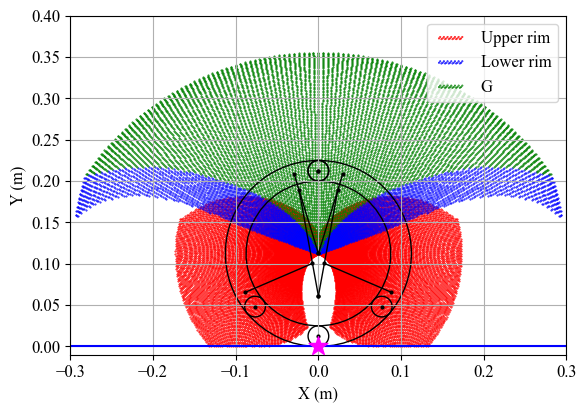

In [4]:
# points that belong to different contact rims.
upper_rim_contact = contact_map.rim == 1    # left rim (right rim is symmetrical with left rim)
lower_rim_contact = contact_map.rim == 2    # left rim (right rim is symmetrical with left rim)
G_contact = contact_map.rim == 3

# foothold (contact points) relative to hip
upper_foothold_imag = linkleg.O1[upper_rim_contact] - 1j*outer_radius
lower_foothold_imag = linkleg.O2[lower_rim_contact] - 1j*outer_radius
G_foothold_imag = linkleg.G[G_contact] - 1j*r

upper_foothold = np.hstack(([upper_foothold_imag.real, upper_foothold_imag.imag], [-upper_foothold_imag.real, upper_foothold_imag.imag]))
lower_foothold = np.hstack(([lower_foothold_imag.real, lower_foothold_imag.imag], [-lower_foothold_imag.real, lower_foothold_imag.imag]))
G_foothold = np.array([G_foothold_imag.real, G_foothold_imag.imag])

# hip position 
contact_points = np.array([0, 0])
hip_positions_upper = contact_points.reshape(2, -1) - upper_foothold
hip_positions_lower = contact_points.reshape(2, -1) - lower_foothold
hip_positions_G = contact_points.reshape(2, -1) - G_foothold

#### plot ####
p_size = 0.2    # point size of each hip position
fig_size = 10
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize = (fig_size,fig_size))
plt.grid(True)
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.01, 0.4)
# hip positions
ax.scatter(hip_positions_upper[0], hip_positions_upper[1], s=p_size, color='r') # , marker='s', s=sizes
ax.scatter(hip_positions_lower[0], hip_positions_lower[1], s=p_size, color='b') # , marker='s', s=sizes
ax.scatter(hip_positions_G[0], hip_positions_G[1], s=p_size, color='g') # , marker='s', s=sizes
ax.legend(('Upper rim', 'Lower rim', 'G'), scatterpoints=20, fontsize=12)
# contact point
ax.scatter( *(contact_points), marker='*', s=p_size*1000, color='magenta', zorder=20) # contact point
# ground
ax.plot([-0.5, 0.5], [0, 0], color='b')
# plot leg
Animation = SingleLeg_Animation.SingleLeg_Animation()
ax = Animation.plot_one(np.deg2rad(17), 0, [0, outer_radius], ax)

# axis
# ax.set_title("Workspace of hip")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# save as pdf
pdf = PdfPages('hip_workspace.pdf')
pdf.savefig(bbox_inches='tight', pad_inches=0)
pdf.close()

# show
plt.show()

Hip position range on stiars

.................................

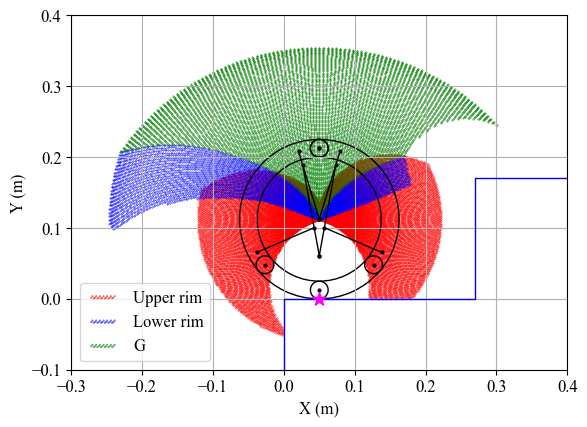

In [5]:
#### Foothold (contact points) when upper rim contact ground. ####
theta_list_upper = []
beta_list_upper =[]
upper_foothold = []
theta, beta, center = upper_contact(0)   # when left upper rim contact ground at alpha = 0  
for alpha in range(131):    # alpha = 0~130 on upper rim
    alpha = np.deg2rad(alpha)
    theta_list_upper.append(theta)
    beta_list_upper.append(beta - alpha)
    upper_foothold.append(center *np.exp(-1j*alpha) - 1j*outer_radius)
upper_foothold = np.array(upper_foothold).flatten()
# add right side into the list
foothold_conjugate = -upper_foothold.real + 1j*upper_foothold.imag   # right lower rim contact ground
upper_foothold = np.append(upper_foothold, foothold_conjugate)
theta_list_upper = np.append(theta_list_upper, theta_list_upper)
beta_list_upper = np.append(beta_list_upper, -np.array(beta_list_upper))

#### Foothold (contact points) when lower rim contact ground. ####
theta_list_lower = []
beta_list_lower =[]
lower_foothold = []
theta, beta, center = lower_contact(0)   # when left lower rim contact ground at alpha = 0
for alpha in range(51): # alpha = 0~50 on lower rim
    alpha = np.deg2rad(alpha)
    theta_list_lower.append(theta)
    beta_list_lower.append(beta - alpha) 
    lower_foothold.append(center *np.exp(-1j*alpha) - 1j*outer_radius)
lower_foothold = np.array(lower_foothold).flatten()
# add right side into the list
foothold_conjugate = -lower_foothold.real + 1j*lower_foothold.imag   # right lower rim contact ground
lower_foothold = np.append(lower_foothold, foothold_conjugate)
theta_list_lower = np.append(theta_list_lower, theta_list_lower)
beta_list_lower = np.append(beta_list_lower, -np.array(beta_list_lower))

#### Foothold (contact points) when G contact ground. ####
theta_list_G = []
beta_list_G = []
G_foothold = []
theta = np.deg2rad(np.arange(17, 160))
beta0 = np.zeros(theta.shape)
contact_map.mapping(theta, beta0)
center = linkleg.G
for alpha in range(-60, 61):    # max alpha (<60) happend when theta = 160 degree
    alpha = np.deg2rad(alpha)
    theta_list_G.append(theta)
    beta_list_G.append(beta0 - alpha)
    G_foothold.append(center *np.exp(-1j*alpha) - 1j*r)
G_foothold = np.array(G_foothold).flatten()
theta_list_G = np.array(theta_list_G).flatten()
beta_list_G = np.array(beta_list_G).flatten()

#### Collision check ####
W = 0.27     # stair width (m) #27 cm
H = 0.17     # stair height (m) #17 cm
initial_foothold = np.array([0.05, 0]) # initial touch point
collision_upper = collision_check(upper_foothold, theta_list_upper, beta_list_upper, initial_foothold)
collision_lower = collision_check(lower_foothold, theta_list_lower, beta_list_lower, initial_foothold)
collision_G = collision_check(G_foothold, theta_list_G, beta_list_G, initial_foothold)

# hip position
hip_positions_upper =  initial_foothold.reshape(2, -1) - np.array([upper_foothold.real, upper_foothold.imag])   # hip position, 2*n  
hip_positions_lower =  initial_foothold.reshape(2, -1) - np.array([lower_foothold.real, lower_foothold.imag])   # hip position, 2*n  
hip_positions_G =  initial_foothold.reshape(2, -1) - np.array([G_foothold.real, G_foothold.imag])   # hip position, 2*n  


#### Plot ####
fig_size = 5
p_size = 0.1   # point size of each hip position
n_stairs = 1  # number of stairs
# fig, ax = plt.subplots(figsize=(fig_size, fig_size))
fig, ax = plt.subplots()
plt.grid(True)
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.3, 0.4)
ax.set_ylim(-0.1, 0.4)
# plot on each stair
for i in range(n_stairs):
    # hip positions for upper rim 
    x_i = hip_positions_upper[0, ~collision_upper] + np.array([i*W])
    y_i = hip_positions_upper[1, ~collision_upper] + np.array([i*H])
    plt.scatter(x_i, y_i, s=p_size, color='r') # , marker='s', s=sizes
    # hip positions for lower rim 
    x_i = hip_positions_lower[0, ~collision_lower] + np.array([i*W])
    y_i = hip_positions_lower[1, ~collision_lower] + np.array([i*H])
    plt.scatter(x_i, y_i, s=p_size, color='b') # , marker='s', s=sizes
    # hip positions for G
    x_i = hip_positions_G[0, ~collision_G] + np.array([i*W])
    y_i = hip_positions_G[1, ~collision_G] + np.array([i*H])
    plt.scatter(x_i, y_i, s=p_size, color='g') # , marker='s', s=sizes
    # contact point
    plt.scatter( *(initial_foothold + [i*W, i*H]), marker='*', s=p_size*1000, color='magenta', zorder=20)
plt.legend(('Upper rim', 'Lower rim', 'G'), scatterpoints=20, fontsize=12)

# stairs
Sx = [ W*j for i in range(-1, n_stairs+1) for j in [i, i+1] ] + [W*(n_stairs+1)]
Sy = [-H] + [ H*j for i in range(-1, n_stairs+1) for j in [i, i+1] ]
plt.plot(Sx, Sy, 'b-', lw=1)
# plot leg
Animation = SingleLeg_Animation.SingleLeg_Animation()
ax = Animation.plot_one(np.deg2rad(17), 0, initial_foothold + [0, outer_radius], ax)
# axis
# ax.set_title("Workspace of hip on stairs")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# save as pdf
pdf = PdfPages('hip_workspace_on_stair.pdf')
pdf.savefig(bbox_inches='tight', pad_inches=0)
pdf.close()

# show
plt.show()

Hip position range on stiars (different foothold on two steps)

..................................................................

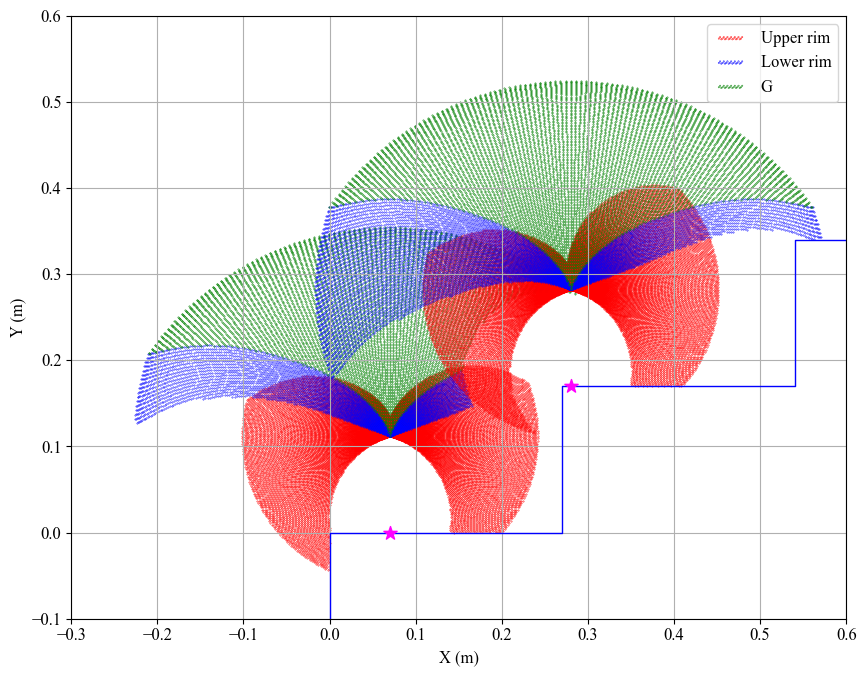

In [6]:
#### Foothold (contact points) when upper rim contact ground. ####
theta_list_upper = []
beta_list_upper =[]
upper_foothold = []
theta, beta, center = upper_contact(0)   # when left upper rim contact ground at alpha = 0  
for alpha in range(131):    # alpha = 0~130 on upper rim
    alpha = np.deg2rad(alpha)
    theta_list_upper.append(theta)
    beta_list_upper.append(beta - alpha)
    upper_foothold.append(center *np.exp(-1j*alpha) - 1j*outer_radius)
upper_foothold = np.array(upper_foothold).flatten()
# add right side into the list
foothold_conjugate = -upper_foothold.real + 1j*upper_foothold.imag   # right lower rim contact ground
upper_foothold = np.append(upper_foothold, foothold_conjugate)
theta_list_upper = np.append(theta_list_upper, theta_list_upper)
beta_list_upper = np.append(beta_list_upper, -np.array(beta_list_upper))

#### Foothold (contact points) when lower rim contact ground. ####
theta_list_lower = []
beta_list_lower =[]
lower_foothold = []
theta, beta, center = lower_contact(0)   # when left lower rim contact ground at alpha = 0
for alpha in range(51): # alpha = 0~50 on lower rim
    alpha = np.deg2rad(alpha)
    theta_list_lower.append(theta)
    beta_list_lower.append(beta - alpha) 
    lower_foothold.append(center *np.exp(-1j*alpha) - 1j*outer_radius)
lower_foothold = np.array(lower_foothold).flatten()
# add right side into the list
foothold_conjugate = -lower_foothold.real + 1j*lower_foothold.imag   # right lower rim contact ground
lower_foothold = np.append(lower_foothold, foothold_conjugate)
theta_list_lower = np.append(theta_list_lower, theta_list_lower)
beta_list_lower = np.append(beta_list_lower, -np.array(beta_list_lower))

#### Foothold (contact points) when G contact ground. ####
theta_list_G = []
beta_list_G = []
G_foothold = []
theta = np.deg2rad(np.arange(17, 160))
beta0 = np.zeros(theta.shape)
contact_map.mapping(theta, beta0)
center = linkleg.G
for alpha in range(-60, 61):    # max alpha (<60) happend when theta = 160 degree
    alpha = np.deg2rad(alpha)
    theta_list_G.append(theta)
    beta_list_G.append(beta0 - alpha)
    G_foothold.append(center *np.exp(-1j*alpha) - 1j*r)
G_foothold = np.array(G_foothold).flatten()
theta_list_G = np.array(theta_list_G).flatten()
beta_list_G = np.array(beta_list_G).flatten()

#### Two steps ####
fig_size = 10
p_size = 0.1   # point size of each hip position
n_stairs = 3  # number of stairs
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
plt.grid(True)
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.3, 0.6)
ax.set_ylim(-0.1, 0.6)
W = 0.27     # stair width (m) #27 cm
H = 0.17     # stair height (m) #17 cm
initial_footholds = np.array([[0.07, 0], [0.01, 0]]) # initial touch point (first step, next step)
for idx, initial_foothold in enumerate(initial_footholds):
    #### Collision check ####
    collision_upper = collision_check(upper_foothold, theta_list_upper, beta_list_upper, initial_foothold, W, H)
    collision_lower = collision_check(lower_foothold, theta_list_lower, beta_list_lower, initial_foothold, W, H)
    collision_G = collision_check(G_foothold, theta_list_G, beta_list_G, initial_foothold, W, H)

    # hip position
    hip_positions_upper =  initial_foothold.reshape(2, -1) - np.array([upper_foothold.real, upper_foothold.imag])   # hip position, 2*n  
    hip_positions_lower =  initial_foothold.reshape(2, -1) - np.array([lower_foothold.real, lower_foothold.imag])   # hip position, 2*n  
    hip_positions_G =  initial_foothold.reshape(2, -1) - np.array([G_foothold.real, G_foothold.imag])   # hip position, 2*n  

    #### Plot ####
    # hip positions for upper rim 
    x_i = hip_positions_upper[0, ~collision_upper] + np.array([idx*W])
    y_i = hip_positions_upper[1, ~collision_upper] + np.array([idx*H])
    plt.scatter(x_i, y_i, s=p_size, color='r') # , marker='s', s=sizes
    # hip positions for lower rim 
    x_i = hip_positions_lower[0, ~collision_lower] + np.array([idx*W])
    y_i = hip_positions_lower[1, ~collision_lower] + np.array([idx*H])
    plt.scatter(x_i, y_i, s=p_size, color='b') # , marker='s', s=sizes
    # hip positions for G
    x_i = hip_positions_G[0, ~collision_G] + np.array([idx*W])
    y_i = hip_positions_G[1, ~collision_G] + np.array([idx*H])
    plt.scatter(x_i, y_i, s=p_size, color='g') # , marker='s', s=sizes
    # contact point
    plt.scatter( *(initial_foothold + idx*np.array([W, H])), marker='*', s=p_size*1000, color='magenta', zorder=20)
plt.legend(('Upper rim', 'Lower rim', 'G'), scatterpoints=20, fontsize=12)

# stairs
Sx = [ W*j for i in range(-1, n_stairs) for j in [i, i+1] ] + [W*n_stairs]
Sy = [-H] + [ H*j for i in range(-1, n_stairs) for j in [i, i+1] ]
plt.plot(Sx, Sy, 'b-', lw=1)

# axis
# ax.set_title("Workspace of hip on stairs")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# show
plt.show()

Hip position range on stiars (only G on current step and lower rim on next step)

.................................

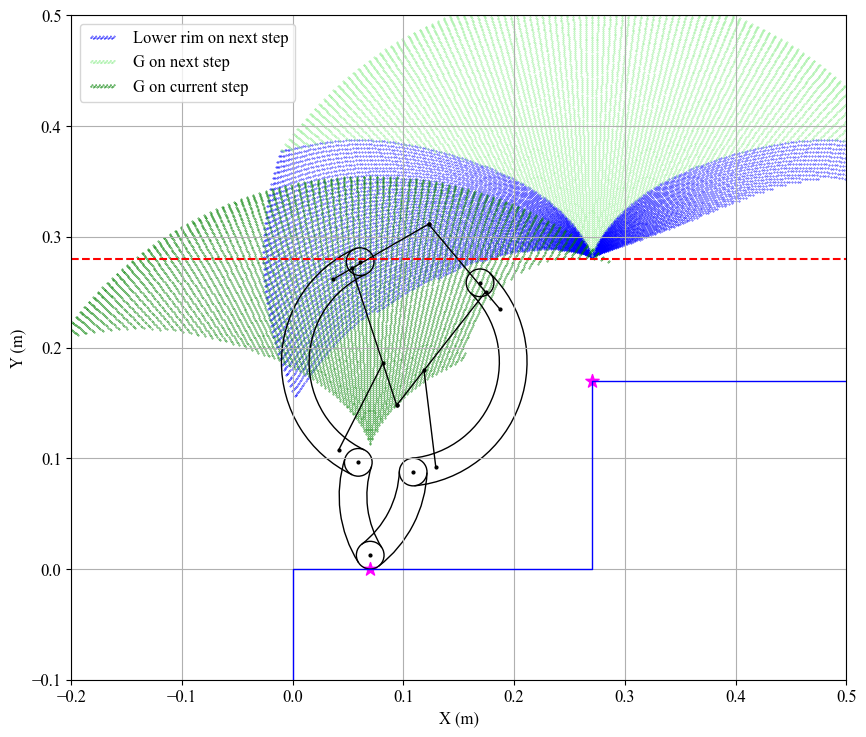

In [7]:
#### Foothold (contact points) when lower rim contact ground. ####
theta_list_lower = []
beta_list_lower =[]
lower_foothold = []
theta, beta, center = lower_contact(0)   # when left lower rim contact ground at alpha = 0
for alpha in range(51): # alpha = 0~50 on lower rim
    alpha = np.deg2rad(alpha)
    theta_list_lower.append(theta)
    beta_list_lower.append(beta - alpha) 
    lower_foothold.append(center *np.exp(-1j*alpha) - 1j*outer_radius)
lower_foothold = np.array(lower_foothold).flatten()
# add right side into the list
foothold_conjugate = -lower_foothold.real + 1j*lower_foothold.imag   # right lower rim contact ground
lower_foothold = np.append(lower_foothold, foothold_conjugate)
theta_list_lower = np.append(theta_list_lower, theta_list_lower)
beta_list_lower = np.append(beta_list_lower, -np.array(beta_list_lower))

#### Foothold (contact points) when G contact ground. ####
theta_list_G = []
beta_list_G = []
G_foothold = []
theta = np.deg2rad(np.arange(17, 160))
beta0 = np.zeros(theta.shape)
contact_map.mapping(theta, beta0)
center = linkleg.G
for alpha in range(-60, 61):    # max alpha (<60) happend when theta = 160 degree
    alpha = np.deg2rad(alpha)
    theta_list_G.append(theta)
    beta_list_G.append(beta0 - alpha)
    G_foothold.append(center *np.exp(-1j*alpha) - 1j*r)
G_foothold = np.array(G_foothold).flatten()
theta_list_G = np.array(theta_list_G).flatten()
beta_list_G = np.array(beta_list_G).flatten()


#### Two steps ####
W = 0.27     # stair width (m) #27 cm
H = 0.17     # stair height (m) #17 cm
initial_footholds = np.array([[0.07, 0], [0.0, 0]]) # initial touch point (first step, next step)

#### Collision check ####
collision_G = collision_check(G_foothold, theta_list_G, beta_list_G, initial_footholds[0], W, H)
collision_lower = collision_check(lower_foothold, theta_list_lower, beta_list_lower, initial_footholds[1], W, H)
collision_G2 = collision_check(G_foothold, theta_list_G, beta_list_G, initial_footholds[1], W, H)

# hip position
hip_positions_G =  initial_footholds[0].reshape(2, -1) - np.array([G_foothold.real, G_foothold.imag])   # hip position, 2*n  
hip_positions_lower =  initial_footholds[1].reshape(2, -1) - np.array([lower_foothold.real, lower_foothold.imag])   # hip position, 2*n  
hip_positions_G2 =  initial_footholds[1].reshape(2, -1) - np.array([G_foothold.real, G_foothold.imag])   # hip position, 2*n  

#### Plot ####
fig_size = 10
p_size = 0.1   # point size of each hip position
n_stairs = 3  # number of stairs
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
plt.grid(True)
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.2, 0.5)
ax.set_ylim(-0.1, 0.5)
# hip positions for lower rim 
x_i = hip_positions_lower[0, ~collision_lower] + np.array([W])
y_i = hip_positions_lower[1, ~collision_lower] + np.array([H])
plt.scatter(x_i, y_i, s=p_size, color='b') # , marker='s', s=sizes
# hip positions for G2
x_i = hip_positions_G2[0, ~collision_G2] + np.array([W])
y_i = hip_positions_G2[1, ~collision_G2] + np.array([H])
plt.scatter(x_i, y_i, s=p_size, color='lightgreen') # , marker='s', s=sizes
# hip positions for G
x_i = hip_positions_G[0, ~collision_G] 
y_i = hip_positions_G[1, ~collision_G]
plt.scatter(x_i, y_i, s=p_size, color='g') # , marker='s', s=sizes
# contact point
plt.scatter( *(initial_footholds[0]), marker='*', s=p_size*1000, color='magenta')
plt.scatter( *(initial_footholds[1] + np.array([W, H])), marker='*', s=p_size*1000, color='magenta')
plt.legend(('Lower rim on next step', 'G on next step', 'G on current step'), loc='upper left', scatterpoints=20, fontsize=12)

# stairs
Sx = [ W*j for i in range(-1, n_stairs) for j in [i, i+1] ] + [W*n_stairs]
Sy = [-H] + [ H*j for i in range(-1, n_stairs) for j in [i, i+1] ]
plt.plot(Sx, Sy, 'b-', lw=1)
# plot leg
Animation = SingleLeg_Animation.SingleLeg_Animation()
contact_map2.calculate(np.deg2rad(130), np.deg2rad(-10))
ax = Animation.plot_one(np.deg2rad(130), np.deg2rad(-10), initial_footholds[0] + [0, r] - [linkleg2.G.real, linkleg2.G.imag], ax)

# axis
# ax.set_title("Workspace of hip on stairs")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
plt.axhline(y=0.28, color='r', linestyle='--', label='Horinoztal line')

# save as pdf
pdf = PdfPages('workspace_overlap.pdf')
pdf.savefig(bbox_inches='tight', pad_inches=0)
pdf.close()

# show
plt.show()

Lower rim rolling forward

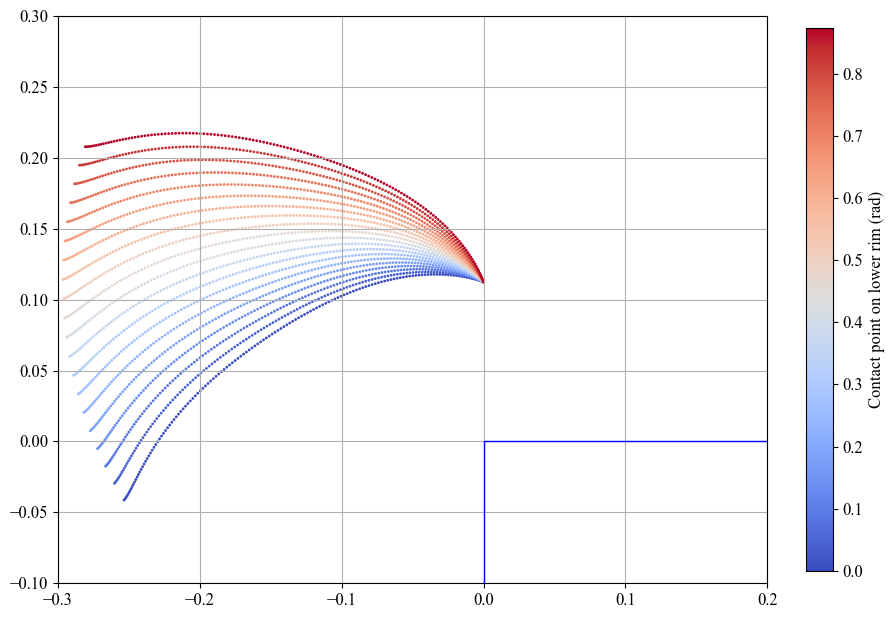

In [8]:
#### Calculate hip positions when left lower rim is contacting ground. ####
samples = 20
hip_positions = []
footholds = []
initial_foothold = np.array([0, 0]) # initial touch point in world coordinate
alpha_list = np.linspace(0*np.pi/180, 50*np.pi/180, samples)    
d_alpha = alpha_list[1] - alpha_list[0]
for alpha in alpha_list:
    theta, beta, center = lower_contact(alpha)
    footholds = center - 1j*outer_radius    # contact points of lower rim relative to hip
    footholds = np.array([footholds.real, footholds.imag])  # 2*n
    hip_positions.append(initial_foothold.reshape(-1, 1) - footholds)
    # initial_foothold[0] += d_alpha*outer_radius # foothold moves forward due to rolling
hip_positions = np.array(hip_positions)  # samples*2*n, haven't taken rolling forward into account.
rolling_distance = alpha_list*outer_radius - alpha_list[0]*outer_radius # samples
# hip_positions[:, 0, :] += rolling_distance.reshape(samples, -1) # take rolling forward into account.
alpha_list_broadcast = np.broadcast_to(alpha_list.reshape(-1, 1), hip_positions[:, 0, :].shape)  # samples -> samples*n

#### Plot ####
fig_size = 10
p_size = 1.0  # point size of each hip position
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
plt.grid(True)
ax.set_aspect('equal')  # 座標比例相同
ax.set_xlim(-0.3, 0.2)
ax.set_ylim(-0.1, 0.3)
color = alpha_list_broadcast
cmap = plt.cm.coolwarm   # color mapping, [viridis, plasma, inferno, magma, Blues, Greens, Reds, coolwarm, RdBu, twilight, Set1, Set2, Set3]
norm = Normalize(vmin=min(alpha_list_broadcast.flatten()), vmax=max(alpha_list_broadcast.flatten()))
x_i = hip_positions[:, 0, :]
y_i = hip_positions[:, 1, :]
scatter = ax.scatter(x_i, y_i, s=p_size, c=color, cmap=cmap, norm=norm) # , marker='s', s=sizes
# ax.scatter( *(current_contact_point + [[i*W], [i*H]]), marker='*', c=pos, cmap=cmap, norm=norm) # contact point
colorbar = plt.colorbar(scatter, ax=ax, fraction=0.035)
colorbar.set_label('Contact point on lower rim (rad)')
# stair
Sx = [0, 0, 0.2]
Sy = [-0.1, 0, 0]
plt.plot(Sx, Sy, 'b-', lw=1)
# show
plt.show()

In [9]:
touch_alpha = (-0.201 > x_i ) & (x_i < -0.199 ) & ( 0.179 < y_i ) & (y_i < 0.181)
in_range = (y_i > 0.18 -0.01 ) & (y_i < 0.18 + 0.01 ) & (x_i > -0.2 ) & (x_i < -0.1 )
alpha_list_broadcast[touch_alpha][0], min(alpha_list_broadcast[in_range]), (min(alpha_list_broadcast[in_range])- alpha_list_broadcast[touch_alpha][0])*outer_radius

(0.6889457573661827, 0.6430160402084372, -0.005167093180246371)

In [10]:
0.01/outer_radius *180 / pi

5.092958178940651